#Libraries and data

In [ ]:
import numpy as np 
import pandas as pd 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns
from sklearn import metrics
from tensorflow.keras.applications import MobileNetV2
from google.colab.patches import cv2_imshow

import xml.etree.ElementTree as ET
from xml.dom import minidom

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1c4EiNosRZ97pWttKwCkE0DX8sao9lB4o"})   # replace the id with id of file you want to access
downloaded.GetContentFile('archive.zip')        # replace the file name with your file

In [ ]:
local_zip = '/content/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()

#Dataset Preprocessing

In [ ]:
images_path = os.path.join("/tmp/train/Medical mask/Medical mask/Medical Mask/images")
train = pd.read_csv(os.path.join("/tmp/train/train.csv"))

images = os.listdir(images_path)
images.sort()


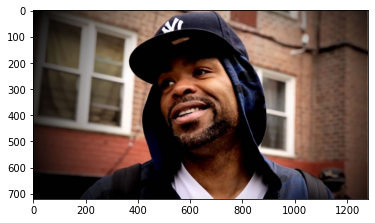

In [ ]:
img = plt.imread(os.path.join(images_path,images[0]))
plt.imshow(img)

In [ ]:
train["classname"].unique()

In [ ]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"] = bbox 

In [ ]:
for j in range(len(train)):
    if (train["classname"][j] == "face_with_mask" or 
        train["classname"][j] == "mask_colorful" or 
        train["classname"][j] == 'mask_surgical' or
        train["classname"][j] == 'face_shield'):
      
          train["classname"][j] = 1
    else:
          train["classname"][j] = 0

In [ ]:
def create_dataset():
    dataset = []
    label = []
    for i in range(len(train)):
        box = train["bbox"][i]
        img = cv2.imread(os.path.join(images_path, train["name"][i]),cv2.IMREAD_GRAYSCALE)
        img = img[box[1]:box[3],box[0]:box[2]]
        try:
          img = cv2.resize(img, (50,50))
          dataset.append([img])
          label.append(train["classname"][i])
        except:
          print("Except: {}\n".format(train["name"][i]))

    return dataset,label

dataset,label = create_dataset()

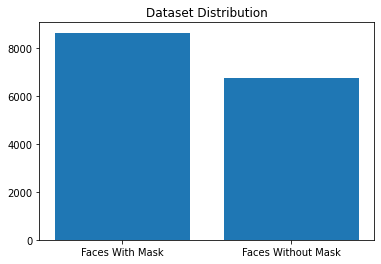

In [ ]:
plt.bar(['Faces With Mask','Faces Without Mask'],train.classname.value_counts())
plt.title("Dataset Distribution")
plt.show()

#Training

In [ ]:
checkpoint_path = "model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = "val_loss",
                                                 save_weights_only=True,
                                                 verbose=0,
                                                 save_best_only=True,
                                                 period=1)

In [ ]:
dataset = np.squeeze(dataset)
dataset = dataset[:,:,:,np.newaxis]

In [ ]:
x_train = np.array(dataset[:12328])
y_train = np.array(label[:12328])
x_test = np.array(dataset[12328:])
y_test = np.array(label[12328:])

In [ ]:
K = keras.backend
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input((50,50,1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128,3,padding="same",activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64,3,padding="same",activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32,3,padding="same",activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(16,3,padding="same",activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 50, 50, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy", f1_m])
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test,y_test), callbacks=cp_callback)

Epoch 1/30
386/386 [==============================] - 11s 10ms/step - loss: 0.6018 - accuracy: 0.6669 - f1_m: 0.6917 - val_loss: 0.5117 - val_accuracy: 0.7476 - val_f1_m: 0.7783
Epoch 2/30
386/386 [==============================] - 3s 9ms/step - loss: 0.5078 - accuracy: 0.7548 - f1_m: 0.7733 - val_loss: 0.4584 - val_accuracy: 0.7866 - val_f1_m: 0.8078
Epoch 3/30
386/386 [==============================] - 3s 9ms/step - loss: 0.4443 - accuracy: 0.7931 - f1_m: 0.8083 - val_loss: 0.4329 - val_accuracy: 0.7992 - val_f1_m: 0.8158
Epoch 4/30
386/386 [==============================] - 3s 9ms/step - loss: 0.4055 - accuracy: 0.8189 - f1_m: 0.8343 - val_loss: 0.4562 - val_accuracy: 0.7879 - val_f1_m: 0.8211
Epoch 5/30
386/386 [==============================] - 3s 9ms/step - loss: 0.3776 - accuracy: 0.8311 - f1_m: 0.8452 - val_loss: 0.3964 - val_accuracy: 0.8145 - val_f1_m: 0.8341
Epoch 6/30
386/386 [==============================] - 3s 9ms/step - loss: 0.3458 - accuracy: 0.8450 - f1_m: 0.8557 - v

#Metrics

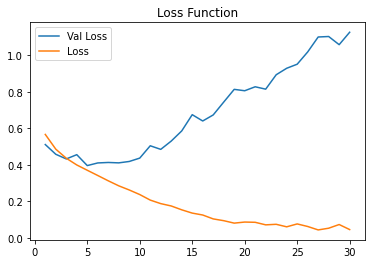

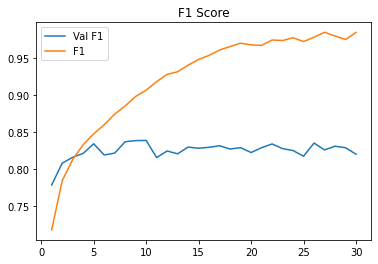

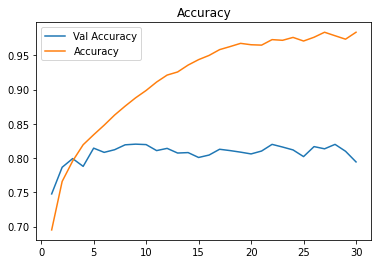

In [ ]:
x = np.linspace(1,30,30)

plt.plot(x,history.history["val_loss"],label="Val Loss")
plt.plot(x,history.history["loss"], label="Loss")
plt.title("Loss Function")
plt.legend()
plt.show()

plt.plot(x,history.history["val_f1_m"],label="Val F1")
plt.plot(x,history.history["f1_m"], label="F1")
plt.title("F1 Score")
plt.legend()
plt.show()

plt.plot(x,history.history["val_accuracy"],label="Val Accuracy")
plt.plot(x,history.history["accuracy"], label="Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

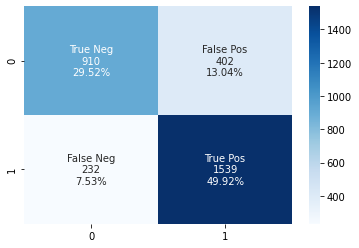

In [ ]:
y_test_predict = model.predict(x_test)

y_test_predict[y_test_predict >= 0.5] = 1
y_test_predict[y_test_predict < 0.5] = 0

cf_matrix = metrics.confusion_matrix(y_test, y_test_predict)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#Transfer Learning - MobileNet V2 architecture

In [ ]:
def create_dataset_rgb():
    dataset = []
    label = []
    for i in range(len(train)):
        box = train["bbox"][i]
        img = cv2.imread(os.path.join(images_path, train["name"][i]))
        img = img[box[1]:box[3],box[0]:box[2]]
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        try:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (96,96))
          dataset.append([img])
          label.append(train["classname"][i])
        except:
          print("Except: {}\n".format(train["name"][i]))
    
    return dataset,label

dataset,label = create_dataset_rgb()

Except: 1861.jpg



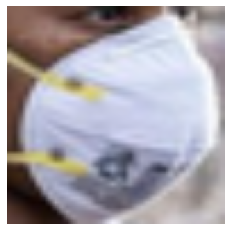

In [ ]:
plt.axis("off")
dataset = np.squeeze(dataset)
plt.imshow(dataset[1500])
plt.show()

In [ ]:
x_train = np.array(dataset[:12328])
y_train = np.array(label[:12328])
x_test = np.array(dataset[12328:])
y_test = np.array(label[12328:])

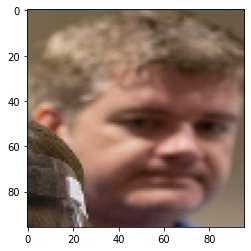

In [ ]:
plt.imshow(dataset[12310])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
_________________

In [ ]:
headModel = base_model.output
headModel = keras.layers.Reshape((3,3,1280))(headModel)
#headModel = keras.layers.AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = keras.layers.Flatten()(headModel)
headModel = keras.layers.Dense(128, activation="relu")(headModel)
headModel = keras.layers.Dense(1, activation="sigmoid")(headModel)

model = keras.models.Model(inputs=base_model.input, outputs=headModel)

for layer in base_model.layers:
	layer.trainable = False

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy", f1_m])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), callbacks=cp_callback)

Epoch 1/10
386/386 [==============================] - 16s 16ms/step - loss: 0.4796 - accuracy: 0.8082 - f1_m: 0.8167 - val_loss: 0.3090 - val_accuracy: 0.8602 - val_f1_m: 0.8692
Epoch 2/10
386/386 [==============================] - 5s 13ms/step - loss: 0.2332 - accuracy: 0.9025 - f1_m: 0.9124 - val_loss: 0.3517 - val_accuracy: 0.8628 - val_f1_m: 0.8814
Epoch 3/10
386/386 [==============================] - 5s 13ms/step - loss: 0.1542 - accuracy: 0.9385 - f1_m: 0.9454 - val_loss: 0.3819 - val_accuracy: 0.8589 - val_f1_m: 0.8783
Epoch 4/10
386/386 [==============================] - 5s 13ms/step - loss: 0.1116 - accuracy: 0.9573 - f1_m: 0.9613 - val_loss: 0.3470 - val_accuracy: 0.8719 - val_f1_m: 0.8831
Epoch 5/10
386/386 [==============================] - 5s 13ms/step - loss: 0.0750 - accuracy: 0.9742 - f1_m: 0.9759 - val_loss: 0.3994 - val_accuracy: 0.8745 - val_f1_m: 0.8829
Epoch 6/10
386/386 [==============================] - 5s 13ms/step - loss: 0.0514 - accuracy: 0.9810 - f1_m: 0.982

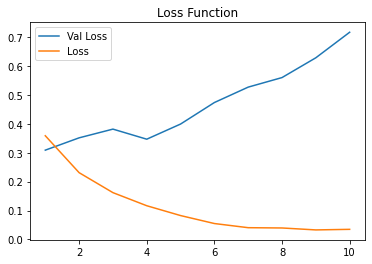

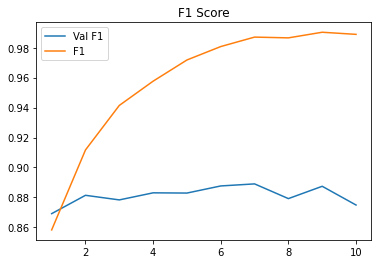

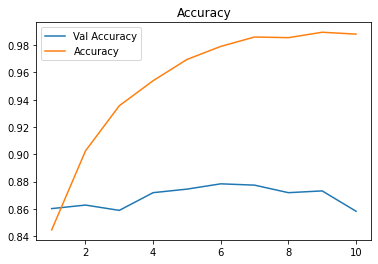

In [ ]:
x = np.linspace(1,10,10)

plt.plot(x,history.history["val_loss"],label="Val Loss")
plt.plot(x,history.history["loss"], label="Loss")
plt.title("Loss Function")
plt.legend()
plt.show()

plt.plot(x,history.history["val_f1_m"],label="Val F1")
plt.plot(x,history.history["f1_m"], label="F1")
plt.title("F1 Score")
plt.legend()
plt.show()

plt.plot(x,history.history["val_accuracy"],label="Val Accuracy")
plt.plot(x,history.history["accuracy"], label="Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

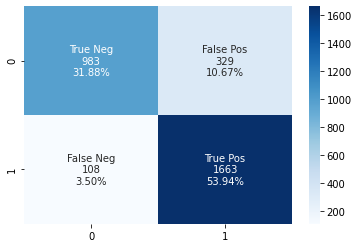

In [ ]:
y_test_predict = model.predict(x_test)

y_test_predict[y_test_predict >= 0.5] = 1
y_test_predict[y_test_predict < 0.5] = 0

cf_matrix = metrics.confusion_matrix(y_test, y_test_predict)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')